### Classificação de Textos em Sites de Notícias sobre Finanças

O seguinte experimento tem como objetivo realizar a classificação de textos para os diferentes tópicos que o site www.sunoresearch.com.br atribui às suas publicações. Os dados foram obtidos com a implementação do crawler, que também está disponibilizada neste repositório.

**Objetivos Principais:**

- Importação dos dados textuais do portal Suno
- Importação dos GloVe Embeddings criados
- Realizar o preprocessamento dos dados textuais
- Implementar a rede CNN
- Avaliar os resultados de classificação com:
    - Somente com o título das notícias (coluna 'title')

In [1]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

---

### 1) Importação dos Dados Textuais

In [2]:
json_data_path = '../crawlers/suno/data/results-full-suno-2020.json'

with open(json_data_path, 'r', encoding='utf8') as json_file:
    data = json.load(json_file)

df_suno = pd.DataFrame(data)

In [3]:
# Convert date to datetime format
df_suno['date'] = pd.to_datetime(df_suno['date'], format='%d/%m/%Y %H:%M')

# Set date column as index
df_suno.set_index('date', inplace=True)

# Order by date
df_suno.sort_index(inplace=True)

In [4]:
df_suno.sample(5)

,topic,title,full_text,url,tags
date,,,,,
2020-10-29 21:30:00,Negócios,Nubank responde Procon-SP sobre cadastros de c...,O Procon-SP informou nessa quinta-feira (29) q...,https://www.sunoresearch.com.br/noticias/nuban...,"[Mercado Pago, Nubank, PIX, Procon]"
2020-08-05 07:11:00,Negócios,"CVC (CVCB3): Morgan Stanley atinge 5,2% de pos...",A CVC (CVCB3) informou aos seus acionistas e a...,https://www.sunoresearch.com.br/noticias/cvc-c...,"[CVC, CVCB3]"
2019-02-08 10:35:00,Política,Fux derruba liminar que evitava cumprimento da...,O ministro Luiz Fux derrubou uma liminar que e...,https://www.sunoresearch.com.br/noticias/fux-d...,"[caminhoneiros, greve dos caminhoneiros, stf]"
2019-10-08 10:46:00,Mercado,"Ibovespa em alta com guerra comercial, reforma...",O Ibovespa inicia nesta terça-feira (8) em alt...,https://www.sunoresearch.com.br/noticias/ibove...,"[acao, Ações, ibovespa]"
2020-09-25 10:59:00,Negócios,Petrobras (PETR4) vende participação de 40% na...,"A Petrobras (PETR4) informou, na manhã desta s...",https://www.sunoresearch.com.br/noticias/petro...,"[desinvestimentos, PETR4, Petrobras]"


In [5]:
df_suno['title'] = df_suno['title'].astype('string')
df_suno['full_text'] = df_suno['full_text'].astype('string')

In [6]:
df_suno.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19344 entries, 2018-08-28 11:12:00 to 2021-01-02 16:36:00
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   topic      19344 non-null  object
 1   title      19344 non-null  string
 2   full_text  19344 non-null  string
 3   url        19344 non-null  object
 4   tags       19344 non-null  object
dtypes: object(3), string(2)
memory usage: 906.8+ KB


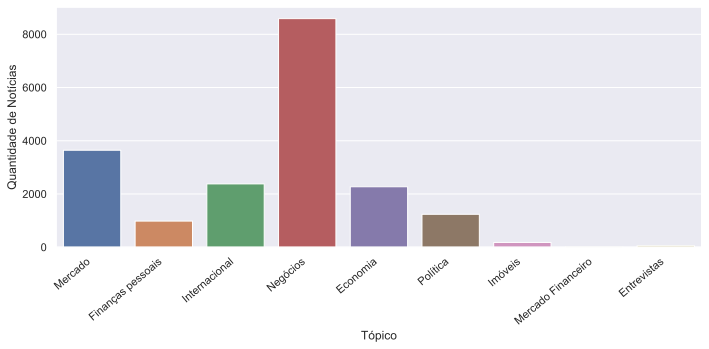

In [7]:
sns.set(style='darkgrid')

plt.figure(figsize=(10, 5))

ax = sns.countplot(df_suno['topic'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.ylabel('Quantidade de Notícias')
plt.xlabel('Tópico')

plt.tight_layout()
plt.show()

In [8]:
df_suno = df_suno[['title', 'full_text', 'topic']]

In [9]:
# Select the main topics
df_suno = df_suno[df_suno['topic'].isin(['Mercado', 'Economia', 'Internacional', 'Negócios'])]

In [10]:
df_suno.sample(5)

,title,full_text,topic
date,,,
2018-11-07 08:41:00,Eleições EUA: democratas levam Câmara; republi...,"Aconteceram ontem (7) as “midterms”, ou eleiçõ...",Internacional
2020-04-20 12:15:00,CVM regulamenta assembleias inteiramente digitais,A Comissão de Valores Mobiliários (CVM) editou...,Mercado
2020-03-11 09:10:00,Agenda do Dia: Oi; IRB; Trisul; Magazine Luiza...,Os assuntos da Agenda do Dia desta quarta-feir...,Negócios
2020-07-28 15:44:00,Tesla recebeu auxilio do governo para reduzir ...,A montadora de carros elétricos Tesla (NASDAQ:...,Negócios
2020-08-29 11:05:00,Le Biscuit apresenta pedido para IPO,A rede de lojas de departamento baiana Le Bisc...,Negócios


---

#### 2) Preprocessamento dos Dados

In [11]:
def remove_emojis(sentence):

    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def remove_valores(sentence):
    new_sentece = ''
    
    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)
        
    return new_sentece

In [12]:
# 1. Aplicar preprocessamento nos títulos e textos completos

# Substituir símbolos importantes
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('-feira', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('+', 'mais '))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('-', 'menos '))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('%', ' por cento'))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('R$', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('U$', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('US$', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('S&P 500', 'spx'))

df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('-feira', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('+', 'mais '))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('-', 'menos '))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('%', ' por cento'))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('R$', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('U$', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('US$', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('S&P 500', 'spx'))

# Transformar em String e Letras Minúsculas nas Mensagens
df_suno['title'] = df_suno['title'].map(lambda s: str(s).lower())
df_suno['full_text'] = df_suno['full_text'].map(lambda s: str(s).lower())

# Remover Pontuações
df_suno['title'] = df_suno['title'].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

# Remover Emojis     
df_suno['title'] = df_suno['title'].map(lambda s: remove_emojis(s))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: remove_emojis(s))

# Quebras de Linha desnecessárias
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('\n', ' '))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('\n', ' '))

# Remover aspas duplas
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('\"', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('“', ''))
df_suno['title'] = df_suno['title'].map(lambda s: s.replace('”', ''))

df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('\"', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('“', ''))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.replace('”', ''))

# Remover valores
df_suno['title'] = df_suno['title'].map(lambda s: remove_valores(s))
df_suno['full_text'] = df_suno['full_text'].map(lambda s: remove_valores(s))

# Espaços desnecessários
df_suno['title'] = df_suno['title'].map(lambda s: s.strip())
df_suno['full_text'] = df_suno['full_text'].map(lambda s: s.strip())

In [13]:
samples = df_suno['title'].values
print (samples[:5])
print (type(samples[0]))

['alta do dólar e paralisia do ibovespa são resultado de negociação do nafta e incerteza sobre o stf'
 'índice spx quebra recorde abrindo acima de <NUM> pela primeira vez'
 'distribuição de dividendos da csn é bloqueada pela justiça'
 'investida agressiva de acionista preocupa gafisa'
 'marfrig anuncia política de limite de alavancagem']
<class 'str'>


In [14]:
# Transformar os tópicos em números inteiros
label_encoder = preprocessing.LabelEncoder()
df_suno['topic_number'] = label_encoder.fit_transform(df_suno['topic'])
class_names = label_encoder.classes_

In [15]:
labels = df_suno['topic_number'].values
print (labels[:5])

[2 1 3 3 3]


In [16]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.3
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

MAX_SEQUENCE_LENGTH = 200

vectorizer = TextVectorization(max_tokens=20000, 
                               output_sequence_length=MAX_SEQUENCE_LENGTH,
                               output_mode='int',
                               dtype=tf.string)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [18]:
vectorizer.get_vocabulary()[:5]

[b'de', b'num', b'em', b'por', b'cento']

In [19]:
output = vectorizer([["o índice bovespa caiu hoje"]])
output.numpy()[0, :6]

array([  25,  418, 2900, 1296,  539,    0], dtype=int64)

In [20]:
voc = [w.decode('utf-8') for w in vectorizer.get_vocabulary()]
word_index = dict(zip(voc, range(len(voc))))

In [21]:
test = ["o", "índice", "bovespa", "caiu", "hoje"]
[word_index[w] for w in test]

[23, 416, 2898, 1294, 537]

In [22]:
path_to_glove_file = "full_text_financial_news_vectors.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 149078 word vectors.


In [23]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8951 words (187 misses)


In [24]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### 3) Modelo CNN
- https://keras.io/examples/nlp/pretrained_word_embeddings/

In [25]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

preds = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         2742000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048 

In [26]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [27]:
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="rmsprop", 
    metrics=["accuracy"]
)

print ('Training CNN model...')
cnn = model.fit(x_train, 
          y_train, 
          batch_size=128, 
          epochs=20, 
          validation_split=0.2)

Training CNN model...
Epoch 1/20
74/74 [==============================] - 3s 43ms/step - loss: 1.1945 - accuracy: 0.5286 - val_loss: 1.0016 - val_accuracy: 0.6413
Epoch 2/20
74/74 [==============================] - 3s 36ms/step - loss: 0.8853 - accuracy: 0.6551 - val_loss: 0.8253 - val_accuracy: 0.6853
Epoch 3/20
74/74 [==============================] - 2s 33ms/step - loss: 0.7189 - accuracy: 0.7341 - val_loss: 0.8500 - val_accuracy: 0.6514
Epoch 4/20
74/74 [==============================] - 2s 33ms/step - loss: 0.5717 - accuracy: 0.8018 - val_loss: 0.6967 - val_accuracy: 0.7576
Epoch 5/20
74/74 [==============================] - 3s 35ms/step - loss: 0.3994 - accuracy: 0.8676 - val_loss: 0.7584 - val_accuracy: 0.7593
Epoch 6/20
74/74 [==============================] - 3s 35ms/step - loss: 0.3008 - accuracy: 0.9025 - val_loss: 0.8243 - val_accuracy: 0.7521
Epoch 7/20
74/74 [==============================] - 2s 33ms/step - loss: 0.2123 - accuracy: 0.9362 - val_loss: 0.9791 - val_accuracy

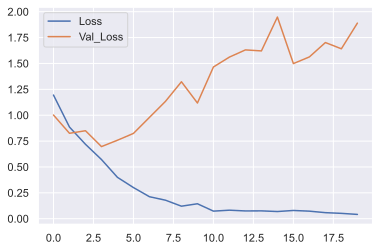

In [28]:
# Loss / Iteration
plt.plot(cnn.history['loss'], label='Loss')
plt.plot(cnn.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

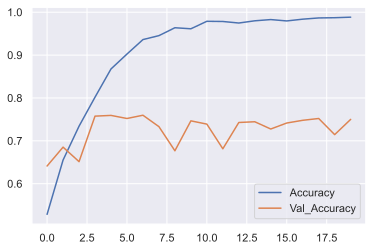

In [29]:
# Accuracy / Iteration
plt.plot(cnn.history['accuracy'], label='Accuracy')
plt.plot(cnn.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.show()

In [30]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

title_example = 'petrobras petr4 reabre plano de demissão voluntária'

probabilities = end_to_end_model.predict(
    [[title_example]]
)

print ("Title Example: '{}'".format(title_example))
print ('Predicted Class: {}'.format(class_names[np.argmax(probabilities[0])]))
print ('Probabilities: {}'.format(probabilities[0]))

Title Example: 'petrobras petr4 reabre plano de demissão voluntária'
Predicted Class: Negócios
Probabilities: [2.3445274e-10 8.6269802e-10 9.7716271e-09 1.0000000e+00]


In [31]:
predicted = model.predict(x_val)

Y_predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_val, Y_predicted, target_names=class_names))
print('Acurácia: {}'.format(metrics.accuracy_score(y_val, Y_predicted)))

               precision    recall  f1-score   support

     Economia       0.75      0.39      0.52       650
Internacional       0.61      0.57      0.59       677
      Mercado       0.88      0.69      0.77      1124
     Negócios       0.75      0.92      0.82      2613

     accuracy                           0.75      5064
    macro avg       0.74      0.64      0.67      5064
 weighted avg       0.76      0.75      0.74      5064

Acurácia: 0.7517772511848341


---